# Requirements

- install node2vec code and add executable to your $PATH (code: https://snap.stanford.edu/node2vec)
- compile GED code (graph embedding divergence), 
  the base implementation of the framework in C (code included, also in      https://github.com/ftheberge/Comparing_Graph_Embeddings) 
- new package to install: 'pip install graphrole'
  

In [3]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
import scipy.sparse.linalg as lg
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_mutual_info_score as AMI
from graphrole import RecursiveFeatureExtractor, RoleExtractor
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import calinski_harabasz_score as CHS
datadir='../Datasets/'

# A few useful functions

In [18]:
def binary_operator(u, v, op='had'):
    if op=='had':
        return u * v
    if op=='l1':
        return np.abs(u - v)
    if op=='l2':
        return (u - v) ** 2
    if op=='avg':
        return (u + v) / 2.0
    
def readEmbedding(fn="_embed", N2K=None):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    if N2K!=None:
        x = [N2K[i] for i in D[0]]
        D[0] = x    
        D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    return Y

## Read embedding from file in node2vec format
## For visualization: use UMAP if dim > 2
def embed2layout(fn="_embed"):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    if Y.shape[1]>2:
        Y = umap.UMAP().fit_transform(Y)
    ly = []
    for v in range(Y.shape[0]):
        ly.append((Y[v][0],Y[v][1]))
    return ly


## Computing JS divergence with GCL model given edgelist, communities and embedding
def JS(edge_file, comm_file, embed_file):
    x = './GED -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    s = subprocess.run(x, shell=True, stdout=subprocess.PIPE)
    x = s.stdout.decode().split(' ')
    div = float(x[1])
    return(div)


## Hope with various Sim
def Hope(g, sim='katz', dim=2, verbose=False, beta=.01, alpha=.5):
    if g.is_directed() == False:
        dim = dim*2
    A = np.array(g.get_adjacency().data)
    beta = beta
    alpha = alpha
    dim = dim
    n = g.vcount()
    ## Katz
    if sim == 'katz':
        M_g = np.eye(n) - beta * A
        M_l = beta * A
    ## Adamic-Adar
    if sim == 'aa':
        M_g = np.eye(n)
        D = np.diag(g.degree())
        M_l = np.dot(np.dot(A,D),A)
    ## Common neighbors
    if sim == 'cn':
        M_g = np.eye(n)
        M_l = np.dot(A,A)
    ## rooted page rank
    if sim == 'rpr':
        P = []
        for i in range(n):
            s = np.sum(A[i])
            P.append([x/s for x in A[i]])
        P = np.array(P)
        M_g = np.eye(n)-alpha*P
        M_l = (1-alpha)*np.eye(n)
    S = np.dot(np.linalg.inv(M_g), M_l)
    u, s, vt = lg.svds(S, k=dim // 2)
    X1 = np.dot(u, np.diag(np.sqrt(s)))
    X2 = np.dot(vt.T, np.diag(np.sqrt(s)))
    X = np.concatenate((X1, X2), axis=1)
    p_d_p_t = np.dot(u, np.dot(np.diag(s), vt))
    eig_err = np.linalg.norm(p_d_p_t - S)
    if verbose:
        print('SVD error (low rank): %f' % eig_err)
    if g.is_directed() == False:
        d = dim//2
        return X[:,:d]
    else:
        return X

## save to disk to compute divergence
def saveEmbedding(X, g, fn='_embed'):
    with open(fn,'w') as f:
        f.write(str(X.shape[0]) + " " + str(X.shape[1])+'\n')
        for i in range(X.shape[0]):
            f.write(g.vs[i]['name']+' ')
            for j in range(X.shape[1]):
                f.write(str(X[i][j])+' ')
            f.write('\n')
            
## Laplacian eigenmaps
def LE(g, dim=2):
    L_sym = np.array(g.laplacian(normalized=True))
    w, v = lg.eigs(L_sym, k=dim + 1, which='SM')
    idx = np.argsort(w) # sort eigenvalues
    w = w[idx]
    v = v[:, idx]
    X = v[:, 1:]
    return X.real

def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)


In [5]:
## To produce LaTeX from a DataFrame
#df = df.round(decimals=3)
#print(df.to_latex(index=False))
#print(df.to_latex(index=True))

# Figure 6.1

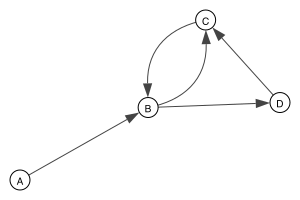

In [6]:
## To illustrate random walks
g = ig.Graph.Erdos_Renyi(n=4,p=0,directed=True)
g.vs['label'] = ['A','B','C','D']
g.vs['color'] = 'white'
g.add_edges([(0,1),(1,2),(1,3),(2,1),(3,2)])
ig.plot(g,'tiny.eps',bbox=(0,0,300,200),vertex_label_size=10)

# Prepare or load datasets

* g: small ABCD graph (100 nodes), mainly for visualization and quick exampes
* G: large ABCD graph (1000 nodes), for experiments
* z: zachary graph, for visualzation

## 1. Small ABCD graph 

100 vertices, 350 edges, avg degreee 7.0 communities 3


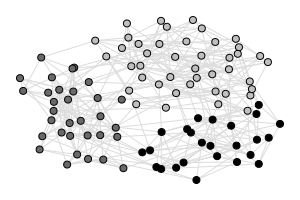

In [5]:
## read graph and communities
g = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_small_cm.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_small_cm_comms.dat',dtype='uint16',usecols=(1))
g.vs['comm'] = [c[int(x['name'])-1] for x in g.vs]
## print a few stats
print(g.vcount(),'vertices,',g.ecount(),'edges,','avg degreee',np.mean(g.degree()),'communities',max(g.vs['comm']))
## ground truth
gt = {k:(v-1) for k,v in enumerate(g.vs['comm'])}
## map between int(name) to key
n2k = {int(v):k for k,v in enumerate(g.vs['name'])}
## store graph partitions via ecg for later example
#ecg = g.community_ecg(min_weight=.5) ## increase min weight for tiny graphs
#with open('abcd_cm_small.ecg','w')as fn:
#    for i in range(len(ecg.membership)):
#        fn.write(str(ecg.membership[n2k[i+1]])+'\n')

## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
g.vs['size'] = 7
g.es['color'] = cls_edges
g.vs['color'] = [cls[i-1] for i in g.vs['comm']]
ig.plot(g, 'abcd.eps', bbox=(0,0,300,200))

## 2. Larger ABCD graph

In [7]:
## read graph and communities
G = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_cm.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_cm_comms.dat',dtype='uint16',usecols=(1))
G.vs['comm'] = [c[int(x['name'])-1] for x in G.vs]
## print a few stats
print(G.vcount(),'vertices,',G.ecount(),'edges,','avg degreee',np.mean(G.degree()),'communities',max(G.vs['comm']))
## ground truth
GT = {k:(v-1) for k,v in enumerate(G.vs['comm'])}
## map between int(name) to key
N2K = {int(v):k for k,v in enumerate(G.vs['name'])}

## store graph partitions via ecg for later experiments
#ECG = G.community_ecg() 
#print(G.gam(GT,ECG),G.gam(GT,G.community_multilevel()),G.gam(GT,G.community_infomap()))
#with open('abcd_cm.ecg','w')as fn:
#    for i in range(len(ECG.membership)):
#        fn.write(str(ECG.membership[N2K[i+1]])+'\n')

## define the colors and node sizes here
cls_edges = 'gainsboro'
G.vs['size'] = 5
G.es['color'] = cls_edges
G.vs['color'] = 'black'
ig.plot(G, bbox=(0,0,400,300)) ## communities are far from obvious in 2d layout!

1000 vertices, 8327 edges, avg degreee 16.654 communities 12


## 3. Zachary (karate) graph


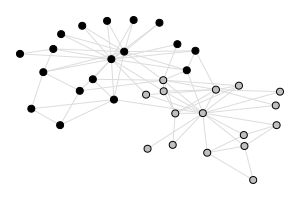

In [8]:
z = ig.Graph.Famous('zachary')

## we'll need these file for embedding lateer on
# Z = np.array(z.get_edgelist())
# with open('zachary.edgelist','w') as fn:
#     for x in Z:
#         fn.write(str(x[0])+' '+str(x[1])+'\n')
# Z = z.community_ecg().membership
# with open('zachary.ecg','w') as fn:
#     for x in Z:
#         fn.write(str(x)+'\n')

z.vs['size'] = 7
z.vs['name'] = [str(i) for i in range(z.vcount())]
z.es['color'] = cls_edges
z.vs['comm'] = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
z.vs['color'] = [cls[i*2] for i in z.vs['comm']]
ig.plot(z, 'zachary.eps', bbox=(0,0,300,200))

# Show various 2d layouts using small Zachary graph

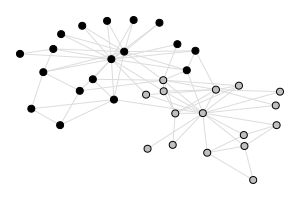

In [9]:
ly = z.layout('kk')
ig.plot(z, 'layout_kk.eps', layout=ly, bbox=(0,0,300,200))


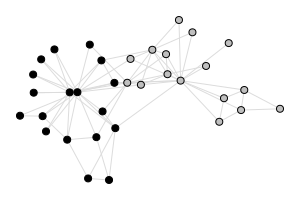

In [10]:
ly = z.layout('fr')
ig.plot(z, 'layout_fr.eps', layout=ly, bbox=(0,0,300,200))

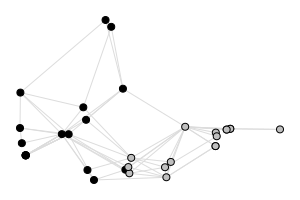

In [11]:
ly = z.layout('mds')
ig.plot(z, 'layout_mds.eps', layout=ly, bbox=(0,0,300,200))

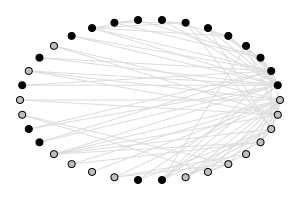

In [12]:
ly = z.layout('circle')
ig.plot(z, 'layout_circle.eps', layout=ly, bbox=(0,0,300,200))

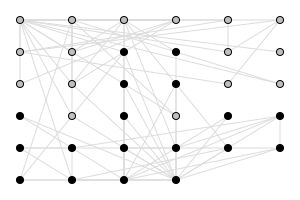

In [13]:
ly = z.layout('grid')
ig.plot(z, 'layout_grid.eps', layout=ly, bbox=(0,0,300,200))

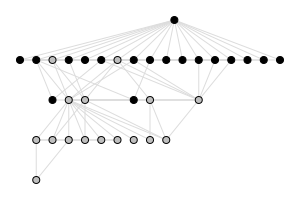

In [15]:
ly = z.layout('sugiyama')
ig.plot(z, 'layout_tree.eps', layout=ly, bbox=(0,0,300,200))

# Perform several embeddings -- Zachary graph
* node2vec from source code
* HOPE with different similarities
* Laplacian Eigenmaps
* visualize some good and bad results

We use the framework to compute divergence (GED.c)

In [23]:
L = []

## Hope
for dim in [2,4,8,16]:
    for sim in ['katz','aa','cn','rpr']:
        X = Hope(z,sim=sim,dim=dim) 
        saveEmbedding(X,z)
        jsd = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed')
        L.append([dim,'hope',sim,jsd])

## LE
for dim in [2,4,8,16]:
    X = LE(z,dim=dim)
    saveEmbedding(X,z)
    jsd = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed')
    L.append([dim,'le',' ',jsd])
    
## node2vec is in my path
for dim in [2,4,8,16]:
    for (p,q) in [(1,0),(0,1),(1,1)]:
        x = 'node2vec -i:'+datadir+'Zachary/zachary.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x)
        jsd = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed')
        L.append([dim,'n2v',str(p)+' '+str(q),jsd])


In [24]:
D = pd.DataFrame(L,columns=['dim','algo','param','jsd'])
D = D.sort_values(by='jsd',axis=0)
D.head()

,dim,algo,param,jsd
18,8,le,,0.001003
31,16,n2v,1 1,0.001150
28,8,n2v,1 1,0.001275
25,4,n2v,1 1,0.001589
11,8,hope,rpr,0.001843


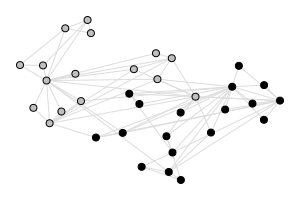

In [25]:
## re-run and plot top result
dim, algo, param, div = D.iloc[0]
if algo=='n2v':
    s = param.split()
    p = float(s[0])
    q = float(s[1])
    x = 'node2vec -i:'+datadir+'Zachary/zachary.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
elif algo=='hope':
    X = Hope(z,sim=param,dim=dim)
    saveEmbedding(X,z) 
else:
    X = LE(z,dim=dim)
    saveEmbedding(X,z)

l = embed2layout()
z.vs['ly'] = [l[int(v['name'])] for v in z.vs]

ig.plot(z, 'zac_high.eps', layout=z.vs['ly'], bbox=(0,0,300,200))


In [26]:
D.tail()

,dim,algo,param,jsd
20,2,n2v,1 0,0.010406
23,4,n2v,1 0,0.010582
21,2,n2v,0 1,0.010771
2,2,hope,cn,0.010993
0,2,hope,katz,0.011100


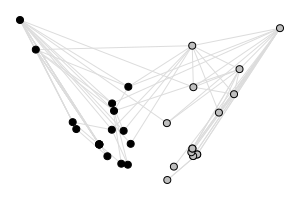

In [27]:
## plot bottom one
dim, algo, param, div = D.iloc[-1]
if algo=='n2v':
    s = param.split()
    p = float(s[0])
    q = float(s[1])
    x = 'node2vec -i:'+datadir+'Zachary/zachary.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
elif algo=='hope':
    X = Hope(z,sim=param,dim=dim)
    saveEmbedding(X,z) 
else:
    X = LE(z,dim=dim)
    saveEmbedding(X,z)

l = embed2layout()
z.vs['ly'] = [l[int(v['name'])] for v in z.vs]
ig.plot(z, 'zac_low.eps', layout=z.vs['ly'], bbox=(0,0,300,200))



# Perform several embeddings -- small ABCD  graph
* node2vec from source code
* HOPE different similarities
* Laplacian Eigenmaps
* visualize some good and bad results

In [33]:
L = []
DIM = [2,4,8,16,24,32]

## Hope
for dim in DIM:
    for sim in ['katz','aa','cn','rpr']:
        X = Hope(g,sim=sim,dim=dim) 
        saveEmbedding(X,g)
        jsd = JS(datadir+'ABCD/abcd_small_cm.dat',datadir+'ABCD/abcd_small_cm.ecg','_embed')
        L.append([dim,'hope',sim,jsd])

## LE
for dim in DIM:
    X = LE(g,dim=dim)
    saveEmbedding(X,g)
    jsd = JS(datadir+'ABCD/abcd_small_cm.dat',datadir+'ABCD/abcd_small_cm.ecg','_embed')
    L.append([dim,'le',' ',jsd])
    
## node2vec is in my path
for dim in DIM:
    for (p,q) in [(1,0),(1,.5),(0,1),(.5,1),(1,1)]:
        x = 'node2vec -i:'+datadir+'ABCD/abcd_small_cm.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x)
        jsd = JS(datadir+'ABCD/abcd_small_cm.dat',datadir+'ABCD/abcd_small_cm.ecg','_embed')
        L.append([dim,'n2v',str(p)+' '+str(q),jsd])


In [34]:
D = pd.DataFrame(L,columns=['dim','algo','param','jsd'])
D = D.sort_values(by='jsd',axis=0)
D.head()

,dim,algo,param,jsd
23,32,hope,rpr,0.000081
12,16,hope,katz,0.000090
19,24,hope,rpr,0.000121
28,24,le,,0.000128
26,8,le,,0.000129


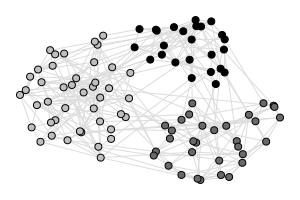

In [36]:
## re-run top one and plot
dim, algo, param, div = D.iloc[0]
if algo=='n2v':
    s = param.split()
    p = float(s[0])
    q = float(s[1])
    x = 'node2vec -i:'+datadir+'ABCD/abcd_small_cm.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
elif algo=='hope':
    X = Hope(g,sim=param,dim=dim)
    saveEmbedding(X,g) 
else:
    X = LE(g,dim=dim)
    saveEmbedding(X,g)

l = embed2layout()
g.vs['ly'] = [l[int(v['name'])-1] for v in g.vs]
ig.plot(g, layout=g.vs['ly'], bbox=(0,0,300,200))


In [37]:
D.tail()

,dim,algo,param,jsd
9,8,hope,aa,0.001908
3,2,hope,rpr,0.002504
1,2,hope,aa,0.002680
2,2,hope,cn,0.002776
0,2,hope,katz,0.002778


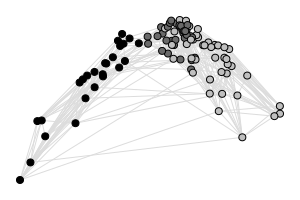

In [38]:
## bottom one(s)
dim, algo, param, div = D.iloc[-1]
if algo=='n2v':
    s = param.split()
    p = float(s[0])
    q = float(s[1])
    x = 'node2vec -i:'+datadir+'ABCD/abcd_small_cm.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
elif algo=='hope':
    X = Hope(g,sim=param,dim=dim)
    saveEmbedding(X,g) 
else:
    X = LE(g,dim=dim)
    saveEmbedding(X,g)

l = embed2layout()
g.vs['ly'] = [l[int(v['name'])-1] for v in g.vs]
ig.plot(g, layout=g.vs['ly'], bbox=(0,0,300,200))


# Large ABCD graph -- find a good embedding with the framework
* we only look as 16 configurations with HOPE for now
* we'll consider more in the large classification experiment later

In [39]:
%%time

## this is slower - we try 16 combinations with HOPE
## store in _embed_best
L = []
jsd_best = 1
DIM = [16,32,48,64]

## Hope
for dim in DIM:
    for sim in ['katz','aa','cn','rpr']:
        X = Hope(G, sim=sim, dim=dim) 
        saveEmbedding(X,G)
        jsd = JS(datadir+'ABCD/abcd_cm.dat',datadir+'ABCD/abcd_cm.ecg','_embed')
        L.append([dim,'hope',sim,jsd])
        if jsd<jsd_best:
            jsd_best=jsd
            os.system('cp _embed abcd_cm_embed_best')


CPU times: user 45.6 s, sys: 2.28 s, total: 47.9 s
Wall time: 2min 57s


In [40]:
## this is saved as _embed_best
D = pd.DataFrame(L,columns=['dim','algo','param','jsd'])
D = D.sort_values(by='jsd',axis=0)
D.head(1)


,dim,algo,param,jsd
15,64,hope,rpr,0.000626


# Classification on larger ABCD graph

* we use a random forest model on embedded space
* we split the data as train and test
* the goal is to recover the communities for each node


In [41]:
## used saved embedding
X = readEmbedding(fn="abcd_cm_embed_best")
y = G.vs['comm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)


In [42]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)

# Class predictions on test data
y_pred = model.predict(X_test)

In [43]:
## Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
## percent correct
print('\naccuracy:',sum(cm.diagonal())/sum(sum(cm)))

[[83  2  2  0  0  1  1  0  2  0  1  0]
 [ 0 75  1  1  1  0  0  2  0  0  0  0]
 [ 2  0 70  1  1  0  0  0  2  0  0  0]
 [ 1  1  2 64  0  0  0  0  1  1  0  0]
 [ 0  1  1  1 77  1  0  1  0  0  1  0]
 [ 1  1  1  0  0 53  0  1  0  0  0  0]
 [ 2  1  0  0  0  3 54  2  2  0  0  0]
 [ 0  0  0  1  0  0  1 42  0  0  0  0]
 [ 0  0  1  0  0  0  0  1 46  0  0  0]
 [ 1  0  0  0  0  2  0  0  1 43  0  0]
 [ 0  0  0  1  0  0  0  0  0  0 41  0]
 [ 1  1  1  0  0  1  2  2  1  0  0 38]]

accuracy: 0.9146666666666666


In [44]:
## For LaTeX file
#print(bmatrix(cm)+'\n')

In [45]:
## compare with random classifier -- assuming we know only the number of classes
y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True)]
cm = confusion_matrix(y_test, y_pred)
# print(cm)
## percent correct
print('\nAccuracy:',sum(cm.diagonal())/sum(sum(cm)))


Accuracy: 0.08533333333333333


In [46]:
## compare with random classifier -- using class proportions in training data
ctr = Counter(y_train)
x = [ctr[i+1] for i in range(12)]
s = np.sum(x)
p = [i/s for i in x]
y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True,p=p)]
cm = confusion_matrix(y_test, y_pred)
# print(cm)
## percent correct
print('\nAccuracy:',sum(cm.diagonal())/sum(sum(cm)))


Accuracy: 0.108


# Clustering
* we run graph clustering (Louvain, ECG)
* we compare with vector space embedding using same embedding
* we use k-means (various k) and DBSCAN
* recall there are 12 ground truth community

In [47]:
X = readEmbedding(fn="abcd_cm_embed_best")

In [48]:
L = []
K = [6,9,12,15,24] ## for k-means
REP = 30

for i in range(REP):
    
    ## kmeans
    for k in K:
        cl = KMeans(n_clusters=k).fit(X)
        d = {k:v for k,v in enumerate(cl.labels_)}
        scr = CHS(X,cl.labels_)
        ami = AMI(list(GT.values()),list(d.values()))
        L.append(['km'+str(k),scr,ami])

    ## ECG
    ec = G.community_ecg().membership
    scr = G.modularity(ec)
    ami = AMI(list(GT.values()),ec)
    L.append(['ecg',scr,ami])
    
    ## Louvain -- permute as this is not done in igraph
    p = np.random.permutation(G.vcount()).tolist()
    GG = G.permute_vertices(p)
    l = GG.community_multilevel().membership
    ll = [-1]*len(l)
    for i in range(len(l)):
        ll[i] = l[p[i]]
    scr = G.modularity(ll)
    ami = AMI(list(GT.values()),ll)
    L.append(['ml',scr,ami])

In [49]:
## results with best score for 3 algorithms
D = pd.DataFrame(L,columns=['algo','scr','ami'])

x = list(D[[x.startswith('km') for x in D['algo']]].sort_values(by='scr',ascending=False)['ami'])[0]
print('K-Means:',x)

x = list(D[D['algo']=='ml'].sort_values(by='scr',ascending=False)['ami'])[0]
print('Louvain:',x)

x = list(D[D['algo']=='ecg'].sort_values(by='scr',ascending=False)['ami'])[0]
print('ECG:',x)


K-Means: 0.9639117652848322
Louvain: 0.9639612134459006
ECG: 0.9952939155260988


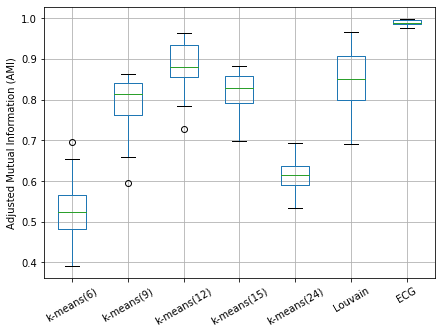

In [50]:
## boxplot AMI results
A = []
algo = ['km6','km9','km12','km15','km24','ml','ecg']
for a in algo:
    A.append(D[D['algo']==a]['ami'])

B = pd.DataFrame(np.transpose(A), 
                 columns=['k-means(6)','k-means(9)','k-means(12)','k-means(15)',
                          'k-means(24)','Louvain','ECG'])
B.boxplot(rot=30,figsize=(7,5))
plt.ylabel('Adjusted Mutual Information (AMI)');
#plt.savefig('embed_cluster.eps')

In [52]:
## DBSCAN -- best results -- we tried different epsilon and dim
## test via calinski_harabasz_score or silhouette_score or davies_bouldin_score
## best result with min_samples = 8
top = 0
for dim in [4,8,16,24,32,40,48,64]:
    for ms in [8]:
        U = umap.UMAP(n_components=24).fit_transform(X)
        for e in np.arange(.40,.50,.0025):
            cl = DBSCAN(eps=e, min_samples=ms ).fit(U)
            labels = cl.labels_
            s = CHS(U,labels) ## score
            if s>top:
                top=s
                e_top=e
                d_top=dim
                m_top=ms
#print(d_top,e_top)
U = umap.UMAP(n_components=d_top).fit_transform(X)
cl = DBSCAN(eps=e_top, min_samples=ms).fit(U)

b = [x>-1 for x in cl.labels_]
l = list(GT.values())
v = [l[i] for i in range(len(l)) if b[i]]
print('AMI without outliers:',AMI(v,cl.labels_[b]))

8 0.4975000000000001
AMI without outliers: 0.8769821712480677


In [54]:
print('AMI with outliers:',AMI(list(GT.values()),cl.labels_))


AMI with outliers: 0.6322340439959995


# Link prediction

* we drop 10% edges and re-compute the embedding (same parameters as best one)
* we train a logistic regression model
* we use validation set to pick best operator
* we apply final model to test set

Link/edge embeddings for the positive and negative edge samples is obtained
by applying a binary operator on the embeddings of the source and target nodes 
of each sampled edge. We consider 4 different operators and select via validation.


In [55]:
## pick 10% edges at random, save new graph as Gp
test_size = int(np.round(.1*G.ecount()))
test_eid = np.random.choice(G.ecount(),size=test_size,replace=False)
Gp = G.copy()
Gp.delete_edges(test_eid)

## compute embedding on Gp 
X = Hope(G,sim='rpr',dim=64)


In [56]:
## validation round in Gp to select oerator
for op in ['had','l1','l2','avg']:
    ## all edges (positive cases)
    F = []
    for e in Gp.es:
        F.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
    size = len(F)
    f = [1]*size

    ## features for node pairs without edges
    ctr = 0
    while ctr < size:
        e = np.random.choice(Gp.vcount(),size=2,replace=False)
        if Gp.get_eid(e[0],e[1],directed=False,error=False) == -1:
            F.append(binary_operator(X[e[0]],X[e[1]],op=op))
            ctr += 1
    F = np.array(F)
    f.extend([0]*size)
    X_train, X_test, y_train, y_test = train_test_split(F, f, test_size=0.1, random_state=0)

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier with',op,'on validation set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier with had on validation set: 0.80
Accuracy of logistic regression classifier with l1 on validation set: 0.82
Accuracy of logistic regression classifier with l2 on validation set: 0.81
Accuracy of logistic regression classifier with avg on validation set: 0.55


In [57]:
## Train model with best operator (here 'l1' but this may vary)
op = 'l1'
F = []
for e in Gp.es:
    F.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
size = len(F)
f = [1]*size

## features for node pairs without edges
ctr = 0
while ctr < size:
    e = np.random.choice(Gp.vcount(),size=2,replace=False)
    if Gp.get_eid(e[0],e[1],directed=False,error=False) == -1:
        F.append(binary_operator(X[e[0]],X[e[1]],op=op))
        ctr += 1
F = np.array(F)
f.extend([0]*size)
logreg = LogisticRegression()
logreg.fit(F,f)

## prepare test set -- dropped edges from G and random pairs
## all edges (positive cases)
op = 'l1'
X_test = []
for i in test_eid:
    e = G.es[i]
    X_test.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
size = len(X_test)
y_test = [1]*size

ctr = 0
while ctr < size:
    e = np.random.choice(G.vcount(),size=2,replace=False)
    if G.get_eid(e[0],e[1],directed=False,error=False) == -1:
        X_test.append(binary_operator(X[e[0]],X[e[1]],op=op))
        ctr += 1
X_test = np.array(X_test)
y_test.extend([0]*size)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier with',op,'on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
confusion_matrix(y_test, y_pred)


Accuracy of logistic regression classifier with l1 on test set: 0.82


array([[685, 148],
       [159, 674]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


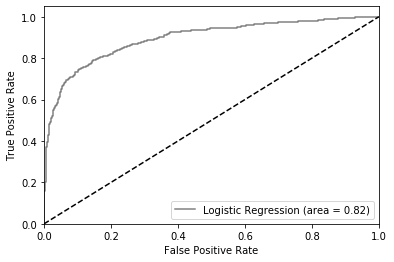

In [58]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='gray',label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")
plt.savefig('embed_link.eps')
plt.show()

## Larger study -- use accuracy for picking embedding

- we training-validation-test split
- this can be long to run -- a pickle file with the results is included
- to re-run from scratch, uncomment the next cell

In [59]:
# save L and train/val/test ids
#pickle.dump( (id_train,id_val,id_trainval,id_test,L), open( "abcd_cm_embeddings.pkl", "wb" ) )

## load L and train/val/test ids
id_train,id_val,id_trainval,id_test,L = pickle.load(open(datadir+"ABCD/abcd_cm_embeddings.pkl","rb"))
y_all = G.vs['comm']
y_train = [y_all[i] for i in id_train]
y_trainval = [y_all[i] for i in id_trainval]
y_val = [y_all[i] for i in id_val]
y_test = [y_all[i] for i in id_test]

In [60]:
R = pd.DataFrame(L,columns=['dim','algo','param','div','acc'])
from scipy.stats import kendalltau as tau
print(tau(R['div'],R['acc']))


KendalltauResult(correlation=-0.33311936759290756, pvalue=8.141998195150794e-05)


In [61]:
## sort by Divergence on validation set
R = R.sort_values(by='div',axis=0,ascending=True)
size = R.shape[0]
R['rank_div'] = np.arange(1,size+1,1)
R.head()


,dim,algo,param,div,acc,rank_div
63,32,n2v,0.5 1,0.000385,0.740,1
51,16,n2v,1 0.5,0.000395,0.772,2
66,48,n2v,1 0.5,0.000398,0.684,3
56,24,n2v,1 0.5,0.000449,0.712,4
68,48,n2v,0.5 1,0.000535,0.684,5


In [62]:
## sort by Accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
size = R.shape[0]
R['rank_acc'] = np.arange(1,size+1,1)
R.head()


,dim,algo,param,div,acc,rank_div,rank_acc
34,48,hope,rpr,0.000746,0.948,13,1
22,16,hope,rpr,0.001331,0.944,25,2
26,24,hope,rpr,0.001218,0.944,24,3
6,48,le,0,0.000597,0.932,9,4
5,32,le,0,0.000670,0.932,10,5


In [63]:
## quite a range of accuracy on the validation set!
R.tail()

,dim,algo,param,div,acc,rank_div,rank_acc
47,8,n2v,0 1,0.003627,0.180,48,66
8,2,hope,aa,0.003633,0.180,69,67
35,2,n2v,1 0,0.002013,0.180,29,68
42,4,n2v,0 1,0.003525,0.156,46,69
37,2,n2v,0 1,0.003633,0.120,65,70


In [64]:
## retrain and score in order of validation set's accuracy
## and aply to test set.

top_acc = []
for i in range(size):
    dim, algo, param, div, acc, rk_a, rk_d = R.iloc[i]
    if algo=='n2v':
        s = param.split()
        p = float(s[0])
        q = float(s[1])
        x = 'node2vec -i:'+datadir+'ABCD/abcd_cm.dat -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x)
        X = readEmbedding(N2K=N2K)
    if algo=='hope':
        X = Hope(G,sim=param,dim=dim)
    if algo=='le':
        X = LE(G, dim=dim)
        
    X_trainval = X[id_trainval,:]
    X_test = X[id_test,:]
    # Create the model with 100 trees
    model = RandomForestClassifier(n_estimators=100, 
                                   bootstrap = True,
                                   max_features = 'sqrt')
    # Fit on training data
    model.fit(X_trainval, y_trainval)

    # Actual class predictions
    y_pred = model.predict(X_test)
    scr = accuracy_score(y_test,y_pred)
    top_acc.append(scr)

R['test'] = top_acc
print('mean accuracy over all models on test set:',np.mean(R['test']))

mean accuracy over all models on test set: 0.5953714285714287


In [65]:
R = R.sort_values(by='test',axis=0,ascending=False)
R['rank_test'] = np.arange(1,size+1,1)
R.head()

,dim,algo,param,div,acc,rank_div,rank_acc,test,rank_test
30,32,hope,rpr,0.001024,0.932,21,6,0.958,1
3,16,le,0,0.000875,0.908,19,8,0.956,2
6,48,le,0,0.000597,0.932,9,4,0.954,3
5,32,le,0,0.000670,0.932,10,5,0.954,4
4,24,le,0,0.000757,0.924,15,7,0.950,5


In [66]:
## top results on test set w.r.t. divergence on validation set
R = R.sort_values(by='div',axis=0,ascending=True)
top_div = R['test'][:10]

## top results on test set w.r.t. accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
top_acc = R['test'][:10]


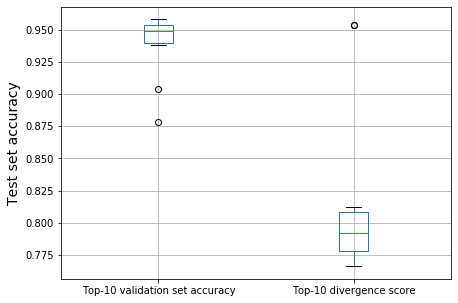

In [67]:
## pd with mu
B = pd.DataFrame(np.transpose(np.array([top_acc,top_div])), 
                 columns=['Top-10 validation set accuracy','Top-10 divergence score'])
B.boxplot(rot=0,figsize=(7,5))
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('embed_classify.eps')

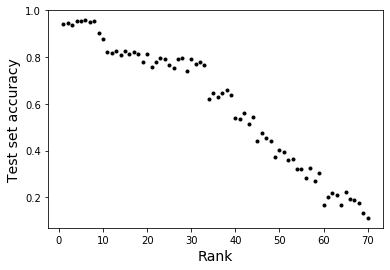

In [68]:
plt.plot(R['rank_acc'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_accuracy.eps');

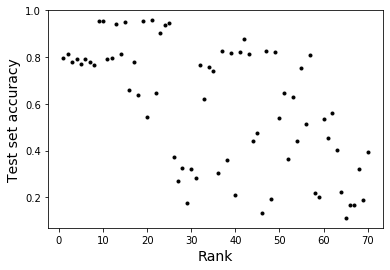

In [69]:
plt.plot(R['rank_div'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_divergence.eps');

In [70]:
## random classification -- AMI
ctr = Counter(y_trainval)
x = [ctr[i+1] for i in range(12)]
s = np.sum(x)
p = [i/s for i in x]
y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True,p=p)]
cm = confusion_matrix(y_test, y_pred)
print('\nRandom classifier accuracy on test set:',sum(cm.diagonal())/sum(sum(cm)))



Random classifier accuracy on test set: 0.09


## ReFex: illustrate roles on Zachary graph

We use the 'graphrole' package


In [71]:
# extract features
feature_extractor = RecursiveFeatureExtractor(z, max_generations=5)
features = feature_extractor.extract_features()
print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
features.head(10)


Features extracted from 3 recursive generations:


,external_edges(mean),degree,degree(sum),external_edges,internal_edges,degree(mean),external_edges(mean)(mean)
0,24.937500,16,69.0,17,34,4.312500,19.637500
1,27.666667,9,52.0,19,21,5.777778,22.422685
2,27.100000,10,66.0,34,21,6.600000,25.537083
3,25.666667,6,46.0,20,16,7.666667,23.717361
4,16.000000,3,23.0,16,5,7.666667,17.979167
5,13.000000,4,25.0,15,7,6.250000,17.234375
6,13.000000,4,25.0,15,7,6.250000,17.234375
7,22.500000,4,41.0,25,10,10.250000,26.342708
8,25.000000,5,59.0,44,10,11.800000,27.214363
9,26.000000,2,27.0,25,2,13.500000,28.108824


In [73]:
# assign node roles in a dictionary
role_extractor = RoleExtractor(n_roles=3)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles
role_extractor.role_percentage.head()

,role_0,role_1,role_2
0,0.835323,0.066075,0.098602
1,0.603568,0.274359,0.122073
2,0.420363,0.064326,0.515310
3,0.511453,0.359224,0.129323
4,0.307913,0.668059,0.024028


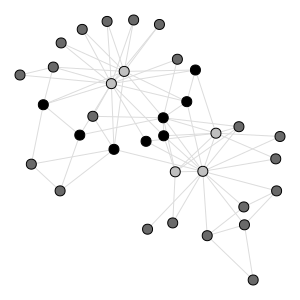

In [74]:
#import seaborn as sns
# build color palette for plotting
unique_roles = sorted(set(node_roles.values()))
#color_map = sns.color_palette('Paired', n_colors=len(unique_roles))

# map roles to colors
role_colors = {role: cls[i] for i, role in enumerate(unique_roles)}

# store colors for all nodes in G
z.vs()['color'] = [role_colors[node_roles[node]] for node in range(z.vcount())]

## Plot with node labels
z.vs()['size'] = 10
#z.vs()['label'] = [v.index for v in z.vs()]
z.vs()['label_size'] = 0
ig.plot(z, 'refex.eps', bbox=(0,0,300,300)) 
